# Question: 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd

from cvxpy.reductions.solvers.defines import installed_solvers
print(installed_solvers())


['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [34]:
# load the dataset
train_data = pd.read_csv('train_svm.csv', names=['x1', 'x2', 'y'], header=None)
test_data = pd.read_csv('test_svm.csv', names=['x1', 'x2', 'y'], header=None)
print("Training data looks like: \n",train_data.head())

# Define the variables
params = cp.Variable((3, ))  # w1, w2, b

# Define the objective
objective = cp.Minimize(cp.norm(params[0:2], 2)**2 / 2)

# Define the constraints - one per training example in matrix form
# Y @ A @ [w, b].T >= 1 
rhs = np.ones((train_data.shape[0], ))
A_matrix = train_data[['x1', 'x2']].to_numpy()
y_values = train_data['y'].to_numpy()   
y_matrix = np.diag(y_values)
A_matrix = np.hstack((A_matrix, np.ones((A_matrix.shape[0], 1))))

constraint = [cp.matmul(y_matrix, A_matrix @ params) >= rhs]
problem = cp.Problem(objective, constraint)

# Solve the problem
problem.solve()

# print the results
print("Optimal parameters are: ", params.value)
print("Optimal objective value is: ", objective.value)
print("Solver details: ", problem.solver_stats)

Training data looks like: 
         x1      x2  y
0  0.10327  3.9126 -1
1  3.68390  2.7885  1
2  2.80320  1.9121  1
3  0.76037  1.3394 -1
4  3.46940  3.5608  1
Optimal parameters are:  [ 11.25572679  -1.97366043 -17.88944473]
Optimal objective value is:  65.29336055826558
Solver details:  SolverStats(solver_name='CLARABEL', solve_time=0.000200087, setup_time=None, num_iters=10, extra_stats=None)


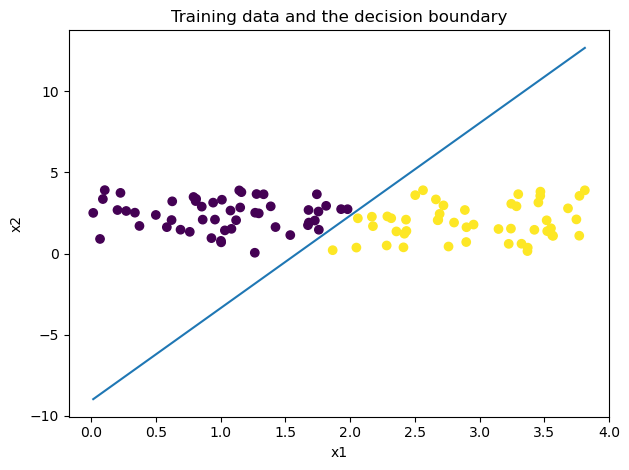

In [37]:
# Plot the line and the training data
plt.figure()
plt.scatter(train_data['x1'], train_data['x2'], c=train_data['y'])
# The line is given by f(x) = w1*x1 + w2*x2 + b = 0
min_x1, max_x1 = train_data['x1'].min(), train_data['x1'].max()
min_x2, max_x2 = train_data['x2'].min(), train_data['x2'].max()
x1 = np.linspace(min_x1, max_x1, 100)
x2 = (-params.value[0] * x1 - params.value[2]) / params.value[1]
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training data and the decision boundary')
plt.tight_layout()
# save as png
plt.savefig('svm_train.png')

In [40]:
# test the model
test_data['prediction'] = test_data['x1']*params.value[0] + test_data['x2']*params.value[1] + params.value[2]
test_data['prediction'] = test_data['prediction'].apply(lambda x: 1 if x > 0 else -1)
test_data['correct'] = test_data['prediction'] == test_data['y']
accuracy = test_data['correct'].sum() / test_data.shape[0]
print("Accuracy on test data is: ", accuracy)

Accuracy on test data is:  0.9766666666666667


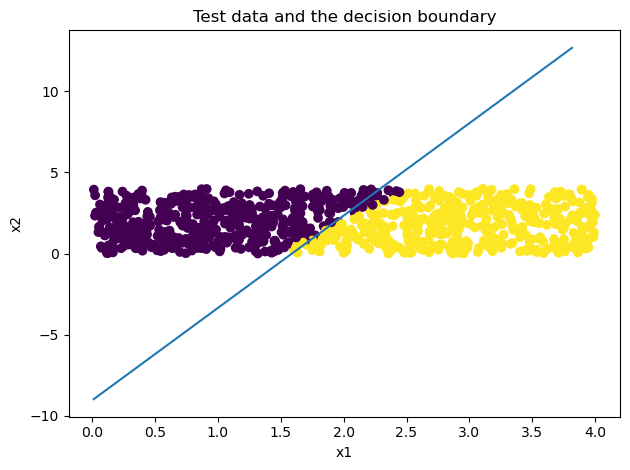

In [39]:
# plot the test data
plt.figure()
plt.scatter(test_data['x1'], test_data['x2'], c=test_data['y'])
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')

# plot the decision boundary
plt.title('Test data and the decision boundary')
plt.tight_layout()
plt.savefig('svm_test.png')
# print("Accuracy on test data is: ", accuracy)


## Question-3

In [64]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# load the dataset
train_data = pd.read_csv('train_svm.csv', names=['x1', 'x2', 'y'], header=None)
test_data = pd.read_csv('test_svm.csv', names=['x1', 'x2', 'y'], header=None)


X_train = train_data[['x1', 'x2']].to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


y_train = train_data['y'].to_numpy()
Q_mat = np.outer(y_train, y_train) * np.dot(X_train, X_train.T)

epsilon = 1e-6  # Small regularization constant
Q_mat += epsilon * np.eye(Q_mat.shape[0])


def dual_objective(nu):  # For minimizing
    nu = nu.reshape(-1, 1)
    return -np.sum(nu) + 0.5 * np.sum(nu.T @ Q_mat @ nu)


def dual_constraint(nu):
    return np.dot(nu.ravel(), y_train.ravel())


def dual_grad(nu):
    return -1 + Q_mat @ nu.reshape(-1, 1)


def augmented_lagrangian(nu, lambda_, mu):
    return dual_objective(nu) - lambda_ * dual_constraint(nu) + 0.5 * mu * dual_constraint(nu)**2


def aug_lag_grad(nu, lambda_, mu):
    return dual_grad(nu).ravel() - np.dot(lambda_.ravel(), y_train.ravel()) + mu * dual_constraint(nu) * y_train.ravel()


def sub_problem_solver(nu, lambda_, mu, max_iter=15000, tol=1e-6, inner_lr=0.01):
    nu_prev = np.copy(nu)
    for _ in range(max_iter):
        grad_of_lag = aug_lag_grad(nu_prev, lambda_, mu)
        grad_norm = np.linalg.norm(grad_of_lag)
        inner_lr = 1.0 / (1e-8 + grad_norm)
        nu_new = nu_prev - inner_lr*np.clip(grad_of_lag, -10.0, 10.0)
        # project onto the feasible set
        nu_new = np.maximum(nu_new, 0)
        # Check for convergence
        chng = np.linalg.norm(nu_new - nu_prev)
        if chng < tol:
            print("############# Inner loop converged #############")
            print("############# Reqd tol and actual tol: ", tol, chng)
            break
        nu_prev = nu_new
    return nu_new, chng


def solve_dual_svm(nu_0, lambda_0, num_outer_iter=100, reqd_outer_tol=1e-7,
                   reqd_inner_tol=1e-6):
    # Initialize the variables
    mu0 = 10.0
    inner_tol_omega0 = 1 / mu0
    eta0 = 1.0 / mu0**0.1
    # Start the outer loop
    for i in range(num_outer_iter):
        if i % 5 == 0:
            print("Outer iteration: ", i)
        if i == 0:
            inner_tolerance = inner_tol_omega0
            outer_tolerance = eta0
            lambda_ = lambda_0
            mu = mu0
            nu = nu_0
        nu_updated, chng = sub_problem_solver(
            nu, lambda_, mu, tol=inner_tolerance)
        # Check constraint violation
        constr_violation = np.linalg.norm(dual_constraint(nu_updated))
        print(f"Iteration {i}: Dual Objective = {dual_objective(nu_updated):.4f}, "
              f"Constraint Violation = {constr_violation:.4e}, "
              f"mu = {mu:.4f}, Change = {chng:.4e} \n")
        if constr_violation < outer_tolerance:
            # test for convergence
            if constr_violation < reqd_outer_tol and chng < reqd_inner_tol:
                break
            # Update the lambda and mu
            lambda_ = lambda_ - mu * dual_constraint(nu_updated)
            mu = mu  # unchanged
            outer_tolerance = outer_tolerance / mu**0.9
            inner_tolerance = inner_tolerance / mu
        else:
            lambda_ = lambda_
            mu = 10.0 * mu
            outer_tolerance = 1 / mu**0.1
            inner_tolerance = 1 / mu
        nu = nu_updated
    return nu, lambda_, mu, i, outer_tolerance, inner_tolerance


# test the solver
num_pts = X_train.shape[0]
nu_guess = np.ones((num_pts, )) * 1e-2
lambda_guess = np.zeros((num_pts, ))  # np.random.uniform(0, 10, (num_pts, ))

solver_details = solve_dual_svm(nu_guess, lambda_guess)

Outer iteration:  0
############# Inner loop converged #############
############# Reqd tol and actual tol:  0.1 0.09191286599398864
Iteration 0: Dual Objective = -26.4699, Constraint Violation = 1.7987e-01, mu = 10.0000, Change = 9.1913e-02 

############# Inner loop converged #############
############# Reqd tol and actual tol:  0.01 0.00999963666373513
Iteration 1: Dual Objective = 226.5233, Constraint Violation = 9.5690e-02, mu = 10.0000, Change = 9.9996e-03 

Iteration 2: Dual Objective = 40.9692, Constraint Violation = 3.0069e-02, mu = 10.0000, Change = 2.7767e-03 

############# Inner loop converged #############
############# Reqd tol and actual tol:  0.01 0.006538010643454965
Iteration 3: Dual Objective = 40.9745, Constraint Violation = 7.6604e-03, mu = 100.0000, Change = 6.5380e-03 

Iteration 4: Dual Objective = -59.3668, Constraint Violation = 1.2168e-04, mu = 100.0000, Change = 3.1264e-03 

Outer iteration:  5
Iteration 5: Dual Objective = -75.1157, Constraint Violation = 

In [68]:
assert np.all(solver_details[0] >=0)
assert np.isclose(np.dot(solver_details[0], y_train), 0, atol=1e-6)

In [65]:
solver_details

(array([0.00000000e+00, 8.54499768e-03, 8.57132981e-03, 0.00000000e+00,
        8.55730995e-03, 3.25699262e-02, 0.00000000e+00, 0.00000000e+00,
        8.56485637e-03, 0.00000000e+00, 3.07077607e-02, 8.53262017e-03,
        0.00000000e+00, 5.86496861e-03, 0.00000000e+00, 8.55528142e-03,
        8.53907386e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.57322432e-03, 8.57861964e-03, 0.00000000e+00, 0.00000000e+00,
        8.55606509e-03, 8.58112294e-03, 0.00000000e+00, 8.59321931e-03,
        8.55894126e-03, 2.65216229e-02, 8.59130977e-03, 8.55994772e-03,
        0.00000000e+00, 0.00000000e+00, 8.56580884e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.57676908e-03,
        8.54221003e-03, 8.54427881e-03, 8.59151962e-03, 8.54596694e-03,
        8.54019905e-03, 0.00000000e+00, 8.59174327e-03, 0.00000000e+00,
        8.59151368e-03, 2.50710098e-02, 0.00000000e+00, 0.00000000e+00,
        8.58099948e-03, 8.58358995e-03, 8.58969883e-03, 3.260458

In [53]:
def compute_w_b(nu, X, y):
    # Compute the weights
    w = np.sum(nu * y * X.T, axis=1)
    # Compute the bias
    idx = np.argmax(nu)
    b = y[idx] - np.dot(w, X[idx])
    return w, b

w, b = compute_w_b(solver_details[0], X_train, y_train) 
print("Optimal weights are: ", w)
print("Optimal bias is: ", b)
print("Objective value is: ", dual_objective(solver_details[0]))

Optimal weights are:  [16.04075245 -2.63649429]
Optimal bias is:  -0.3724934025995248
Objective value is:  -68.66633657199128


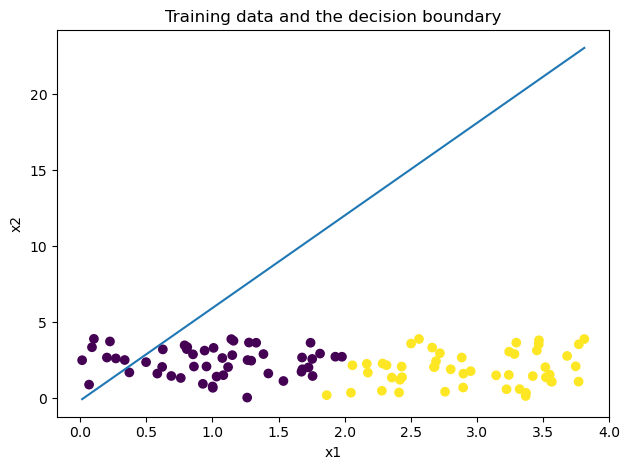

In [55]:
# Plot the line and the training data
plt.figure()
plt.scatter(train_data['x1'], train_data['x2'], c=train_data['y'])
# The line is given by f(x) = w1*x1 + w2*x2 + b = 0
min_x1, max_x1 = train_data['x1'].min(), train_data['x1'].max()
min_x2, max_x2 = train_data['x2'].min(), train_data['x2'].max()
x1 = np.linspace(min_x1, max_x1, 100)
x2 = (-w[0] * x1 - b) / w[1]
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training data and the decision boundary')
plt.tight_layout()
# save as png
plt.savefig('svm_train.png')